
# Spectral analysis with energy-dependent directional cuts

Perform a point like spectral analysis with energy dependent offset cut. We do this on autoMAGIC data and will 
explore some advantages that we get from the autoMAGIC tarballs.


## Context

As already explained in the :doc:`/tutorials/analysis-1d/spectral_analysis`
tutorial, the background is estimated from the field of view of the observation.
In particular, the source and background events are counted within a circular 
ON region enclosing the source. The background to be subtracted is then estimated
from one or more OFF regions with an expected background rate similar to the one
in the ON region (i.e. from regions with similar acceptance).

*Full-containment* IRFs have no directional cut applied, when employed
for a 1D analysis, it is required to apply a correction to the IRF
accounting for flux leaking out of the ON region. This correction is
typically obtained by integrating the PSF within the ON region.

When computing a *point-like* IRFs, a directional cut around the assumed
source position is applied to the simulated events. For this IRF type,
no PSF component is provided. The size of the ON and OFF regions used
for the spectrum extraction should then reflect this cut, since a
response computed within a specific region around the source is being
provided.

The directional cut is typically an angular distance from the assumed
source position, $\theta$. The
[gamma-astro-data-format](https://gamma-astro-data-formats.readthedocs.io/en/latest/)_
specifications offer two different ways to store this information:

* if the same $\theta$ cut is applied at all energies and offsets, a
  [RAD_MAX](https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/point_like/#rad-max)_
  keyword is added to the header of the data units containing IRF components. This
  should be used to define the size of the ON and OFF regions;
* in case an energy-dependent (and offset-dependent) $\theta$ cut is applied, its
  values are stored in additional `FITS` data unit, named
  [RAD_MAX_2D](https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/point_like/#rad-max-2d)_.

`Gammapy` provides a class to automatically read these values,
`~gammapy.irf.RadMax2D`, for both cases (fixed or energy-dependent
$\theta$ cut). In this notebook we will focus on how to perform a
spectral extraction with a point-like IRF with an energy-dependent
$\theta$ cut. We remark that in this case a
`~regions.PointSkyRegion` (and not a `~regions.CircleSkyRegion`)
should be used to define the ON region. If a geometry based on a
`~regions.PointSkyRegion` is fed to the spectra and the background
`Makers`, the latter will automatically use the values stored in the
`RAD_MAX` keyword / table for defining the size of the ON and OFF
regions.

Beside the definition of the ON region during the data reduction, the
remaining steps are identical to the other :doc:`/tutorials/analysis-1d/spectral_analysis`
tutorial., so we will not detail the data reduction steps already
presented in the other tutorial.

**Objective: perform the data reduction and analysis of 2 Crab Nebula
observations of MAGIC and fit the resulting datasets.**

## Introduction

We load our autoMAGIC data containing 
IRF components with a $\theta$ cut.

We define the ON region, this time as a `~regions.PointSkyRegion` instead of a
`CircleSkyRegion`, i.e. we specify only the center of our ON region. This is important for
using the energy-dependent $\theta^2$ cuts.
We create a `RegionGeom` adding to the region the estimated energy
axis of the `~gammapy.datasets.SpectrumDataset` object we want to
produce. The corresponding dataset maker will automatically use the
$\theta$ values in `~gammapy.irf.RadMax2D` to set the
appropriate ON region sizes (based on the offset on the observation and
on the estimated energy binning).

In order to define the OFF regions it is recommended to use a
`~gammapy.makers.WobbleRegionsFinder`, that uses fixed positions for
the OFF regions. In the different estimated energy bins we will have OFF
regions centered at the same positions, but with changing size. As for
the `~gammapy.makers.SpectrumDatasetMaker`, the `~gammapy.makers.ReflectedRegionsBackgroundMaker` will use the
values in `~gammapy.irf.RadMax2D` to define the sizes of the OFF
regions.

Once the datasets with the ON and OFF counts are created, we can perform
a 1D likelihood fit, exactly as illustrated in the previous example.

In the end, we will compute a light curve in different binnings.


In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import PointSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

## Setup

As usual, we’ll start with some setup …




In [2]:
from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset, FluxPointsDataset
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    WobbleRegionsFinder,
)
from gammapy.maps import Map, MapAxis, RegionGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    LogParabolaSpectralModel,
    SkyModel,
    create_crab_spectral_model,
)
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator

## Load data

We load the two MAGIC observations of the Crab Nebula containing the
`RAD_MAX_2D` table.




In [3]:
# Adjust this path to where you copied (and unpacked!) the tarball:
data_store = DataStore.from_dir("/Users/jan-lukas/Desktop/Crab_ST0311_test_analysis")
observations = data_store.get_observations(required_irf="point-like")

len(observations)

250

A `RadMax2D` attribute, containing the `RAD_MAX_2D` table, is
automatically loaded in the observation. As we can see from the IRF
component axes, the table has a single offset value and 28 estimated
energy values.




In [4]:
rad_max = observations["5076459"].rad_max
print(rad_max)

'THETA' axis is stored as a scalar -- converting to 1D array.


RadMax2D
--------

  axes  : ['energy', 'offset']
  shape : (30, 1)
  ndim  : 2
  unit  : deg
  dtype : >f4



We can also plot the rad max value against the energy:




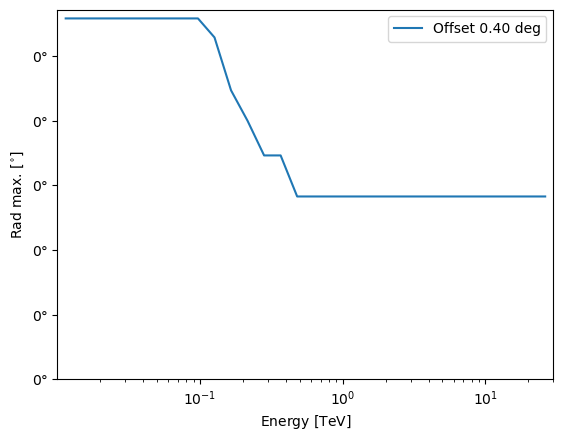

In [5]:
fig, ax = plt.subplots()
rad_max.plot_rad_max_vs_energy(ax=ax)
plt.show()

## Define the ON region

To use the `RAD_MAX_2D` values to define the sizes of the ON and OFF
regions it is necessary to specify the ON region as
a `~regions.PointSkyRegion`:




In [6]:
source_name="CrabNebula"
target_position = SkyCoord.from_name(source_name, frame="icrs", cache=True)
on_region = PointSkyRegion(target_position)

## Definitions for the data reduction chain

We begin with the configuration of the dataset maker classes:




In [7]:
# true and estimated energy axes
energy_axis =MapAxis.from_energy_bounds(0.005, 50, nbin=20, unit="TeV", name="energy")
energy_axis_true = MapAxis.from_energy_bounds(0.005, 50, nbin=25, unit="TeV", name="energy_true")

# geometry defining the ON region and SpectrumDataset based on it
geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)


The `SpectrumDataset` is now based on a geometry consisting of a
single coordinate and an estimated energy axis. The
`SpectrumDatasetMaker` and `ReflectedRegionsBackgroundMaker` will
take care of producing ON and OFF with the proper sizes, automatically
adopting the $\theta$ values in `Observation.rad_max`.

As explained in the introduction, we use a `WobbleRegionsFinder`, to
determine the OFF positions. The parameter `n_off_positions` specifies
the number of OFF regions to be considered.




In [8]:
dataset_maker = SpectrumDatasetMaker(containment_correction=False, use_region_center=True, selection=["counts", "exposure", "edisp"])
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

# tell the background maker to use the WobbleRegionsFinder, let us use 3 off
region_finder = WobbleRegionsFinder(n_off_regions=3)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

# use the energy threshold specified in the DL3 files
safe_mask_masker = SafeMaskMaker(methods=["aeff-default"])

## Explointing the OBS Index File for the Data Selection

Withing the autoMAGIC tarball, we have two powerful files: 

* HDU Index file: Contains information about all the files and where they are stored. This makes it easier to import all the data into Gammapy. However, this means you should not move files within the directory or rename them! 
* OBS Index file: Contains information about the observation conditions such as zenith angle, weather conditions and trigger rates 

With the OBS Index file, cuts on numerous parameters become possible on DL3 level. Let's explore the possibilities and make some cuts for the analysis 

### Weather and Zenith Cuts
Depending on where the information is stored, the logic for making the cuts changes. Information such as the weather conditions, the zenith angle or the L3 rate are contained in the OBS index file and can therefore be cut like this:

In [9]:
zenith_min = 5
zenith_max = 62

obs_ids=[]
for obs in data_store.obs_table:
    if obs['ZENITH']<zenith_max and obs['ZENITH']>=zenith_min:
        if obs['TRANS9'] >= 0.8:
           obs_ids.append(obs['OBS_ID'])
        elif obs['TRANS9'] < 0:
            if obs['CLOUD']<20:
                obs_ids.append(obs['OBS_ID'])

observation_list = data_store.get_observations(obs_ids, required_irf=["aeff", "edisp"])

len(observation_list.ids)

221

### Duration Cuts and Date Cuts
The cuts on parameters that are not in the OBS index file but in the DL3 files themselves works with masks:

In [10]:
# define cuts 
min_duration=300 # seconds
start_date='2018-11-01'
stop_date='2019-03-31'

# Get dates as Asstropy time objects
start_date = Time(start_date, format="iso")
stop_date = Time(stop_date, format="iso")

# get all obs ids
obs_ids = np.array([obs.obs_id for obs in observation_list])

# get the dates and durations of the observations
date = [obs.tstart for obs in observation_list]
duration = np.array([obs.observation_time_duration.value for obs in observation_list])

# create the mask
mask_duration = (duration>=300)
mask_date = (date>=start_date) & (date< stop_date)
mask = mask_date & mask_duration

# apply the mask
obs_ids = obs_ids[mask]

# get the observations that survived the mask
observation_list = data_store.get_observations(obs_ids, required_irf=["aeff", "edisp"])

## Running the Data Reduction Chain

In [11]:
datasets_nebula = Datasets()
for obs in observations:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)
    dataset_on_off = bkg_maker.run(dataset=dataset, observation=obs)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, obs)
    datasets_nebula.append(dataset_on_off)

'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' 

## Defining the Crab Nebula Spectral Model

We have to define the Crab Nebula spectral model because Gammapy does a forward folding and so the spectral shape has to  be known beforehand. FOr gammapy to know  the spectrum we want to use, we add the model to our datasets. The crab spectral model can also be taken from gammapy, but then the uncertainties are not known...

In [12]:
# Crab Nebula Model
model_crab_nebula = LogParabolaSpectralModel.from_log10(alpha=2.51, amplitude="3.39e-11 cm-2 s-1 TeV-1", reference=1 * u.TeV, beta=0.21)
model_crab_nebula.beta.error = 0.03
model_crab_nebula.alpha.error = 0.02
model_crab_nebula.amplitude.error = 0.09 * 1e-11 * u.Unit("TeV-1 cm-2 s-1")
model_crab = SkyModel(spectral_model = model_crab_nebula, name="CrabNebula")

# join datasets and add model
dataset_nebula = Datasets(datasets_nebula).stack_reduce(name="CrabNebula")
dataset_nebula.models = [model_crab]
datasets_nebula.models = [model_crab]


## Fit spectrum

| We perform a joint likelihood fit of the two datasets.
| For this particular datasets we select a fit range between
  $50\,{\rm GeV}$ and $50\,{\rm TeV}$.




In [13]:
# define energy range for the fit
energy_range_crab = [0.05, 30]*u.TeV
mask_fit = geom.energy_mask(energy_min=min(energy_range_crab), energy_max=max(energy_range_crab))
dataset_nebula.mask_fit = mask_fit

fit = Fit()
result = fit.run(datasets=datasets_nebula)

## Compute the Spectral Flux Points



In [14]:
flux_points = FluxPointsEstimator(selection_optional=['all'],energy_edges=energy_axis.edges,source="CrabNebula",n_sigma_ul=2).run(dataset_nebula)
flux_points_dataset = FluxPointsDataset(data=flux_points, models=model_crab)

## Spectrum

Let us compute the spectrum and compare the spectrum we obtained against a [previous measurement
by
MAGIC](https://ui.adsabs.harvard.edu/abs/2015JHEAp...5...30A/abstract)_.




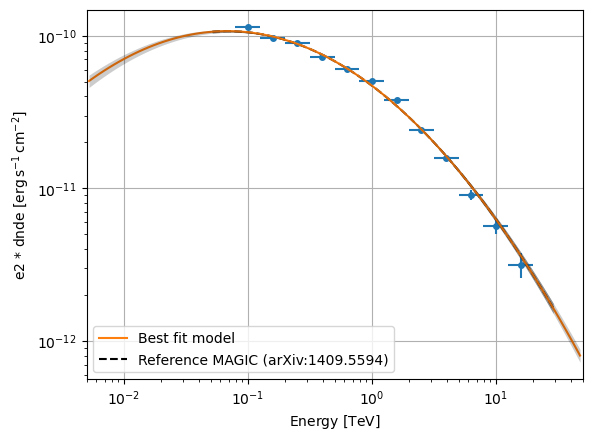

<Figure size 640x480 with 0 Axes>

In [26]:
fig, ax_spectrum = plt.subplots()
flux_points_dataset.plot_spectrum(ax_spectrum)

# Plot the Reference model
model_crab_nebula.plot(
    ax=ax_spectrum,
    energy_bounds=(min(energy_range_crab), max(energy_range_crab)),
    label="Reference MAGIC (arXiv:1409.5594)",
    c="black",
    linestyle="dashed",
    energy_power=2,
)
model_crab_nebula.plot_error(
    ax=ax_spectrum,
    color='black',
    alpha=0.3,
    energy_bounds=(min(energy_range_crab), max(energy_range_crab)),
    energy_power=2,
)

plt.legend()
plt.grid()
plt.show()
plt.clf()

## Light Curve

Apart from the spectrum, we are also interested in the light curve above 300 GeV.


### Run Wise Light Curve

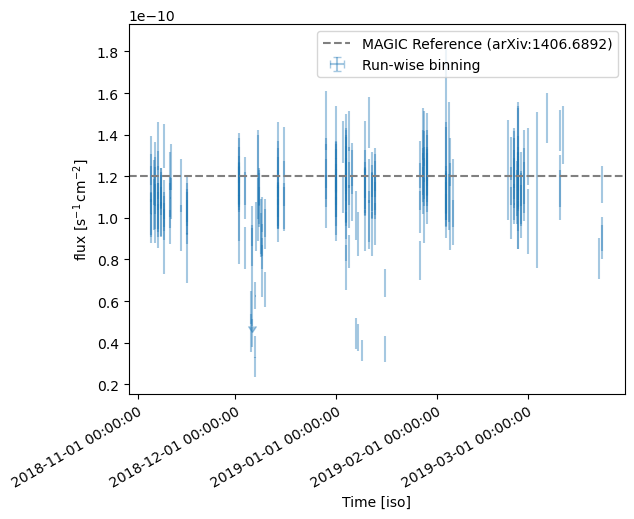

<Figure size 640x480 with 0 Axes>

In [31]:
energy_range_crab_lc = [0.3, 99999]*u.TeV

# run wise
time_intervals_rw = [Time([o.tstart, o.tstop]) for o in observations]
lc_maker_rw = LightCurveEstimator(
    energy_edges=energy_range_crab_lc, 
    time_intervals=time_intervals_rw,
    source=source_name,
    reoptimize=False,
    n_sigma_ul=2,
    selection_optional="all"
)
result_rw = lc_maker_rw.run(datasets_nebula)

fig, ax = plt.subplots()
result_rw.plot(ax=ax, sed_type="flux", marker="",alpha=0.4, label="Run-wise binning")
ax.axhline(y=1.2e-10, linestyle='--', color='Grey', label="MAGIC Reference (arXiv:1406.6892)")
ax.set_yscale('linear')
plt.legend()
plt.show()
plt.clf()

### Night Wise Light Curve

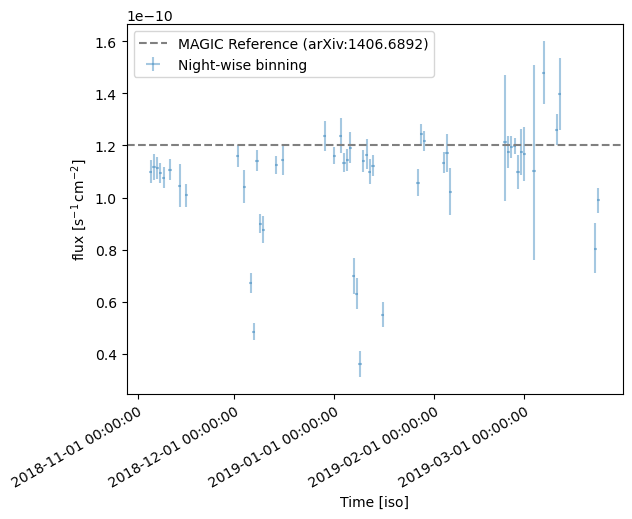

<Figure size 640x480 with 0 Axes>

In [32]:
day_of_first_observation = int(min([o.tstart.mjd for o in observations]))
day_of_last_observation = int(max([o.tstart.mjd for o in observations]))
n_time_bins = day_of_last_observation - day_of_first_observation + 3
edges_time_bins = day_of_first_observation + np.arange(n_time_bins)
time_intervals_nw = [Time([t-0.5, t+0.5], format="mjd") for t in edges_time_bins[:-1]]
lc_maker_nw = LightCurveEstimator(
    energy_edges=energy_range_crab_lc,
    time_intervals=time_intervals_nw,
    source=source_name,
    reoptimize=False,
    n_sigma_ul=2,
    selection_optional="all"
)
result_nw = lc_maker_nw.run(datasets_nebula)

fig, ax = plt.subplots()
result_nw.plot(sed_type="flux", marker="", alpha=0.4, label="Night-wise binning")
ax.axhline(y=1.2e-10, linestyle='--', color='Grey', label="MAGIC Reference (arXiv:1406.6892)")
ax.set_yscale('linear')

plt.legend()
plt.show()
plt.clf()